In [38]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import torch.optim as optim
import torch.nn as nn 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from matplotlib import pyplot as plt 
import torchvision

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data.sampler import SequentialSampler

In [39]:
image_path = []
TRAIN_IMG_DIR = '/kaggle/input/licenseplate/train/images'
for root, dirs, files in os.walk(TRAIN_IMG_DIR):
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

6218

In [40]:
label_path = []
TRAIN_LABEL_DIR = '/kaggle/input/licenseplate/train/labels'
for root, dirs, files in os.walk(TRAIN_LABEL_DIR):
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        label_path.append(path)
len(label_path)

6218

In [41]:
VALID_LABEL_DIR = '/kaggle/input/licenseplate/valid/labels'
VALID_IMG_DIR = '/kaggle/input/licenseplate/valid/images'
TEST_LABEL_DIR = '/kaggle/input/licenseplate/test/labels'
TEST_IMG_DIR = '/kaggle/input/licenseplate/test/images'
WEIGHT = '/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

In [42]:
class LicensePlateFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None, resize=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = os.listdir(image_dir)
        self.resize = resize
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_filename = self.images[index]
        image_path = os.path.join(self.image_dir, image_filename)
        label_path = os.path.join(self.label_dir, image_filename.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)  # Read in BGR format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Parse YOLO annotations
        boxes = []
        labels = []
        if self.resize:
            image = cv2.resize(image, self.resize)  # Resize the image
            # Adjust bounding box coordinates based on the resize factor
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x_center, y_center, width, height = [float(x) for x in line.strip().split()]
                x_min = (x_center - width / 2) * image.shape[1]
                y_min = (y_center - height / 2) * image.shape[0]
                x_max = (x_center + width / 2) * image.shape[1]
                y_max = (y_center + height / 2) * image.shape[0]
                
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_label))
                
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        # Convert boxes and labels to tensors
        
        labels = torch.tensor(labels, dtype=torch.int64)
        # In Faster R-CNN, all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Calculate area of bounding boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([index]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=target["boxes"], labels=target["labels"])
            image = transformed['image']
            target["boxes"] = torch.tensor(transformed['bboxes'])
            target["labels"] = torch.tensor(transformed['labels'])
        else:
            image = transforms.ToTensor()(image)
        return image, target, index


In [43]:
train_transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.2),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))  # Ensure bounding boxes are transformed
val_transform = A.Compose([
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
                ) 


In [44]:
train_dataset = LicensePlateFasterRCNNDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, transforms = train_transform, resize=(640,640))
valid_dataset = LicensePlateFasterRCNNDataset(VALID_IMG_DIR, VALID_LABEL_DIR, transforms = val_transform, resize=(640,640))
test_dataset = LicensePlateFasterRCNNDataset(TEST_IMG_DIR, TEST_LABEL_DIR, transforms = val_transform, resize=(640,640))

[[287 223 440 352]]
(640, 640, 3)
<class 'numpy.ndarray'>


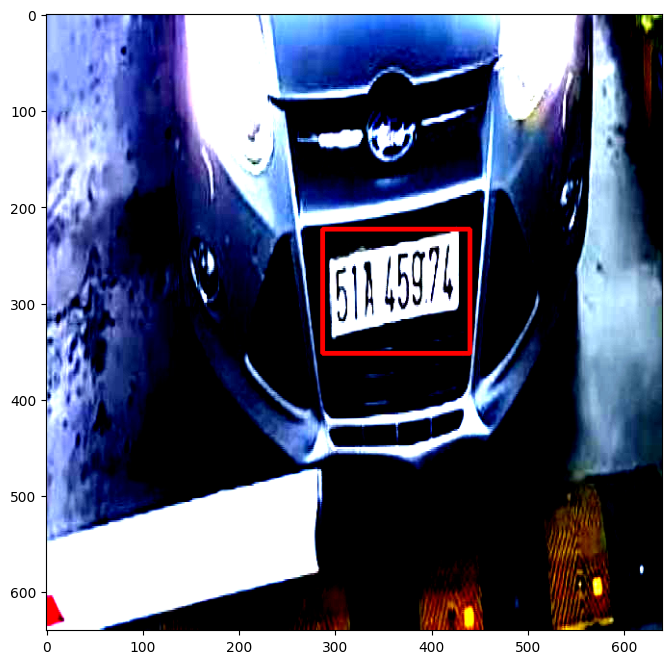

In [45]:
image, target, image_id = train_dataset[0]
# print(image, target)
boxes = target['boxes'].cpu().numpy().astype(np.int32)
print(boxes)
sample = image.permute(1,2,0).cpu().numpy()
print(sample.shape)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
print(type(sample))
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.imshow(sample)

In [46]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [47]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0        

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [49]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 3 # 2 class (license_plate, lights) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [50]:
!pip install wandb
!wandb login 'af3fff39f107c47a5441bad9ba81d9c46a34914b'

^C
ERROR: Operation cancelled by user
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [51]:
import wandb
wandb.init(
    project = 'FasterRCNN',
    name = 'augmented_pretrained',
    config = {
        'architecture': 'Faster RCNN',
        'dataset': 'LicencePlate',
        'epoch': 30
    }
)

In [52]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

num_epochs = 30
best_val_loss = float('inf')
loss_hist = Averager()

for epoch in range(num_epochs):
    loss_hist.reset()
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  ##Return the loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    train_loss = loss_hist.value

#     model.eval()  # Set the model to evaluation mode
    val_loss_hist = Averager()
    with torch.no_grad():  # No need to track gradients during validation
        for images, targets, image_ids in valid_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)  # Compute loss
            losses = sum(loss for loss in loss_dict.values())
            val_loss_hist.send(losses.item())

    # Print and compare validation loss
    val_loss = val_loss_hist.value
    print(f"Epoch #{epoch} loss: {loss_hist.value}, Validation loss: {val_loss}")

    # Save the model if validation loss is lower
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        print(f"Model saved at Epoch #{epoch} with Validation loss: {val_loss}")

    # Update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    wandb.log({'Val_loss': val_loss,
               'Train_loss': train_loss
              })
    print(f"Epoch #{epoch} loss: {loss_hist.value}")

KeyboardInterrupt: 

In [ ]:
# checkpoint = torch.load('/kaggle/input/fastercheckpoint/best_model_checkpoint.pth')
# model.load_state_dict(checkpoint)
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# model.to(device)



In [ ]:
# images, targets, images_id = next(iter(test_data_loader))
# model.eval()
# sample = images[1].unsqueeze(0).to(device)
# output = model(sample)
# print(output)
# boxes = output[0]['boxes'].data.cpu().numpy()
# scores = output[0]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# # print(sample.shape)
# sample = sample.squeeze(0).permute(1,2,0).cpu().numpy()
# print(type(sample))
# plt.imshow(sample)
# for box in boxes:
#     cv2.rectangle(sample,
#                   (box[0], box[1]),
#                   (box[2], box[3]),
#                   (220, 0, 0), 2)
    
# ax.set_axis_off()
# ax.imshow(sample)

In [ ]:
detection_threshold = 0.5

In [ ]:
results = []
# Run inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    for images, targets, image_ids in test_data_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)
        
        for i, output in enumerate(outputs):
            # Retrieve the scores and convert to numpy
            scores = output['scores'].data.cpu().numpy()
            class_ids = output['labels']
            # Retrieve the boxes and convert to numpy
            boxes = output['boxes'].data.cpu().numpy()
            
            # Apply the detection threshold
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            
            # Convert boxes from [x_min, y_min, x_max, y_max] to [x_min, y_min, width, height]
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            
            # Collect results in COCO format
            for class_id, box, score in(zip(class_ids, boxes, scores)):
                result = {
                    "image_id": image_ids[i],
                    "category_id": class_id.item(),
                    "bbox": box.tolist(),  # Convert numpy array to list
                    "score": float(score)  # Convert numpy float to Python float
                }
                results.append(result)


In [ ]:
# Write results to a JSON file
with open('predictions.json', 'w') as f:
    json.dump(results, f)

In [ ]:
import json
import os

# Replace these with the actual paths and values
gt_dir = '/kaggle/input/licenseplate/test/labels'
image_dir = '/kaggle/input/licenseplate/test/images'
output_json_path = 'ground_truths.json'

# Initialize the JSON structure
coco_format = {
    'images': [],
    'annotations': [],
    'categories': []
}

# Let's assume you already have a list of category names and their corresponding IDs
category_id_mapping = {'license plate': 1, 'lights': 0}  # etc.

# Add categories to COCO JSON
for category_name, category_id in category_id_mapping.items():
    coco_format['categories'].append({
        'id': category_id,
        'name': category_name,
        'supercategory': category_name
    })

# Populate images and annotations
annotation_id = 1

# Iterate over the dataset using the DataLoader
for image, targets, image_id in test_dataset:
    # Add image information
    coco_format['images'].append({
        'id': image_id,
        'width': image.shape[2],  # Assuming the image tensor is CxHxW
        'height': image.shape[1]
    })
    
    #lstargets['boxes']: Add annotations
    x_min, y_min, x_max, y_max = targets['boxes'][0]
    width = x_max - x_min
    height = y_max - y_min
    label = targets['labels'][0]
    # Add annotation information
    coco_format['annotations'].append({
        'id': annotation_id,
        'image_id': image_id,
        'category_id': label.item(),
        'bbox': [x_min.item(), y_min.item(), width.item(), height.item()],
        'area': width.item() * height.item(),
        'iscrowd': 0  # or target['iscrowd'] if provided
    })
    annotation_id += 1

# Write the COCO format JSON to a file
with open(output_json_path, 'w') as f:
    json.dump(coco_format, f, indent=2)

In [ ]:
print(len(coco_format['images']))
print(len(results))

In [ ]:
!pip install pycocotools

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Initialize COCO ground truth API
coco_gt = COCO('/kaggle/working/ground_truths.json')  # path to the JSON with ground truth annotations

# Initialize COCO predictions API
coco_dt = coco_gt.loadRes('/kaggle/working/predictions.json')  # path to the JSON with detection results

# Initialize COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Evaluate on a subset of images by setting their ids
# If you want to evaluate on the entire validation set, you can omit this line
coco_eval.params.imgIds = image_ids  # list of image ids to evaluate on

# Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

In [ ]:
!pip install tidecv

In [ ]:
from tidecv import TIDE
import tidecv.datasets as datasets

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(model, dataloader, detection_threshold=0.5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Visualize predictions from a model for one batch of the dataloader.

    Args:
        model (torch.nn.Module): The object detection model.
        dataloader (torch.utils.data.DataLoader): Dataloader for the dataset.
        detection_threshold (float): Threshold for considering detections.
        device (torch.device): The device the model is running on.
    """

    # Get a batch of data
    images, targets, image_ids = next(iter(dataloader))
    model.eval()  # Set the model to evaluation mode
    
    # Select a random image from the batch
    idx = torch.randint(0, len(images), (1,)).item()
    sample = images[idx].unsqueeze(0).to(device)
    
    with torch.no_grad():  # No need to track gradients
        output = model(sample)
    
    # Convert detections to numpy arrays
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    
    # Filter out detections below the threshold
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    
    # Convert the image from tensor to numpy
    sample = sample.squeeze(0).permute(1, 2, 0).cpu().numpy()
    sample = sample * 255.0  # If image was normalized during transformations, adjust values to [0, 255]
    sample = sample.astype(np.uint8)
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Draw the boxes on the image
    for box in boxes:
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)
    
    # Show the image with bounding boxes
    ax.imshow(sample)
    ax.axis('off')  # Disable axis
    plt.show()

visualize_predictions(model, test_data_loader)
